GOAL: Using `nn` module to create neural networks easily.

In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

# Define / Build Neural networks in PyTorch

## Let's design a simple MLP for classifying MNIST images 

<img src="./assets/Part2_figures/example_mlp_arch_mnist.png"></img>

N(0, 1): not recommended

## Load Dataset

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
transform = transforms.ToTensor() # PIL image [0, 255] int === ToTensor() ==> PyTorch Tensor [0, 1] float

# Download and load the training data
trainset = datasets.MNIST(root = '~/.pytorch/MNIST_data/', download=True, train=True, transform=transform) # target_transform
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Let's get a batch of samples:

In [33]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # next()

In [34]:
print(images.shape)

torch.Size([64, 1, 28, 28])


## 1. Using PyTorch Tensors, the most low-level API, for defining the network

In [35]:
def activation(x):
    return 1/(1+torch.exp(-x))

# Flatten the input images
inputs = images.view(images.shape[0], -1) # 64, 1, 28, 28 ===> 64*784
print("inputs shape:", inputs.shape)

# Create parameters
w1 = torch.randn(784, 256)
b1 = torch.randn(256)
print("w1 shape:", w1.shape)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1) # sigmoid(w*x+b)

out = torch.mm(h, w2) + b2  # raw scores  <=> logits
print(out.shape) 

inputs shape: torch.Size([64, 784])
w1 shape: torch.Size([784, 256])
torch.Size([64, 10])


Similar computations just for one sample:

In [36]:
index = 0
inp = inputs[index,:].unsqueeze(0) # [784] ==> [1, 784]   # [64,1,28,28] === squeeze() ===> [64,28,28]

h = activation(torch.mm(inp, w1) + b1)
out = torch.mm(h, w2) + b2

print("logits for one sample from the batch:\n", out)

logits for one sample from the batch:
 tensor([[ 12.0150,   3.1515,   3.1369,  -4.8155,  12.4640, -26.6047,   5.9804,
         -12.1218,  10.9840,  -0.1860]])


sigmoid can bring these values into the range [0,1]:

In [37]:
print(activation(out))

tensor([[9.9999e-01, 9.5897e-01, 9.5839e-01, 8.0377e-03, 1.0000e+00, 2.7908e-12,
         9.9748e-01, 5.4397e-06, 9.9998e-01, 4.5364e-01]])


But, it not a proper probability distribution over the classes.

In [38]:
print(activation(out).sum())

tensor(6.3765)


In the case of multiclass classification, we need to use softmax:

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

The probability distribution over the classes tells us the likely class(es) the image belongs to

In [39]:
out.shape

torch.Size([1, 10])

In [40]:
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)

print(probabilities)
# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1))

tensor([[3.4175e-01, 4.8346e-05, 4.7644e-05, 1.6761e-08, 5.3544e-01, 5.7728e-18,
         8.1833e-04, 1.1252e-11, 1.2189e-01, 1.7175e-06]])
torch.Size([1, 10])
tensor([1.0000])


<BarContainer object of 10 artists>

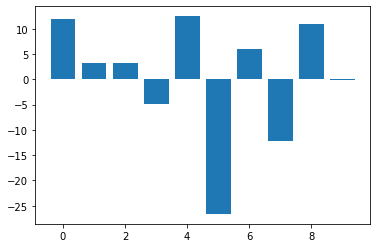

In [41]:
plt.bar(list(range(10)), out.view(-1))

<BarContainer object of 10 artists>

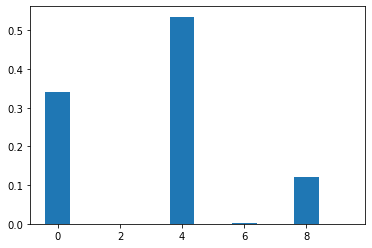

In [42]:
plt.bar(list(range(10)), probabilities.view(-1))

Is that right?

In [43]:
labels[index]

tensor(2)

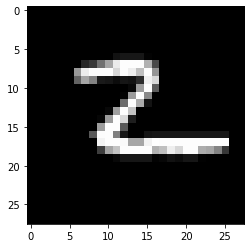

In [44]:
plt.imshow(images[index].numpy().squeeze(), cmap=plt.cm.gray); # images[1,:,:,:]

## 2. Subclassing from `torch.nn.Module`

In [45]:
from torch import nn

In [46]:
class myNet(nn.Module):
    """
    net = myNet()
    """
    def __init__(self):
        super().__init__() # calls the constructor (__init__) of the parent class
        
        self.hidden = nn.Linear(784, 256) # torch.nn.Linear --- z = Wx+b 
        self.output = nn.Linear(256, 10)
        
        self.sigmoid  = nn.Sigmoid()
        self.softmax = nn.Softmax(dim = 1) # 64*784 ==> column-wise computation
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x) # Note: Usually, we do not implement softmax in PyTorch directly. 

In [47]:
model = myNet()
print(model)

myNet(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)


### access to model's parameters

In [48]:
model.hidden.weight.shape

torch.Size([256, 784])

In [51]:
model.hidden.bias.shape

torch.Size([256])

In [54]:
print('Model parameters:')

for param in model.parameters(): 
    print(param.shape)

Model parameters:
torch.Size([256, 784])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


### move the model to GPU

In [56]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
    
print(my_device)

model.to(my_device)

cuda


myNet(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

### 3. Using `torch.nn.Functional` module

In [58]:
import torch.nn.functional as F

In [59]:
class myNet(nn.Module): # Camel Case
    """
    net = myNet()
    """
    def __init__(self):
        super().__init__() # calls the constructor (__init__) of the parent class
        
        self.hidden = nn.Linear(784, 256) # torch.nn.Linear --- z = Wx+b 
        self.output = nn.Linear(256, 10)
        
        # self.sigmoid  = nn.Sigmoid()
        # self.softmax = nn.Softmax(dim = 1) # 64*784 ==> column-wise computation
    
    def forward(self, x):
        x = F.sigmoid(self.hidden(x))
        #x = self.sigmoid(x)
        x = F.softmax(self.output(x))
        #x = self.softmax(x) 

torch.nn.functional.linear(input, weight, bias) # see the documentation

In [60]:
model = myNet()
print(model)

myNet(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)


## 4. Using `nn.Sequential` to build a model

In [61]:
model = nn.Sequential(nn.Linear(784, 256),
                     nn.Sigmoid(),
                     nn.Linear(256, 10),
                     nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=256, out_features=10, bias=True)
  (3): Softmax()
)


In [62]:
model[0] # model.hiddent

Linear(in_features=784, out_features=256, bias=True)

In [63]:
model[0].weight.shape

torch.Size([256, 784])

In [66]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
    ('hidden', nn.Linear(784, 256)),
    ('sigmoid', nn.Sigmoid()),
    ('output', nn.Linear(256, 10)),
    ('softmax', nn.Softmax(dim=1))]))

In [68]:
model.hidden

Linear(in_features=784, out_features=256, bias=True)

In [69]:
print(model)

Sequential(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (sigmoid): Sigmoid()
  (output): Linear(in_features=256, out_features=10, bias=True)
  (softmax): Softmax()
)
